# Chapter 4 : Implementing a GPT model from Scratch To Generate Text

## 4.1 Coding an LLM architecture

Compared to conventional deep learning models, LLMs are larger, mainly due to their vast number of parameters, not the amount of code.

 In the context of deep learning and LLMs like GPT, the term
 "parameters" refers to the trainable weights of the model. These weights are
 essentially the internal variables of the model that are adjusted and optimized
 during the training process to minimize a specific loss function. This
 optimization allows the model to learn from the training data.

Configuration details for the 124 million parameter GPT-2 model include:

In [3]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

"vocab_size" refers to a vocabulary of 50,257 words, as used by the
 BPE tokenizer.

"context_length" denotes the maximum number of input tokens the
 model can handle, via the positional embeddings.

"emb_dim" represents the embedding size, transforming each token into
 a 768-dimensional vector.

 "n_heads" indicates the count of attention heads in the multi-head
 attention mechanism.

 "n_layers" specifies the number of transformer blocks in the model.

 "drop_rate" indicates the intensity of the dropout mechanism.

 "qkv_bias" determines whether to include a bias vector in the Linear
 layers of the multi-head attention for query, key, and value
 computations.

Below are the steps in order we are going to implement the architecture.

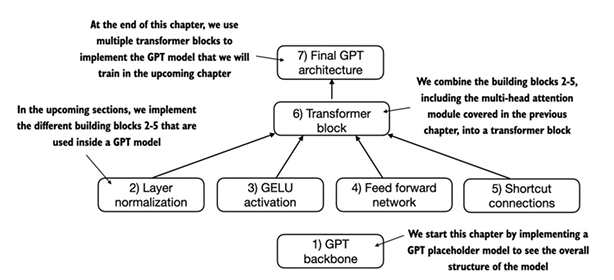

Let's start with step 1, a placholder GPT backbone.

In [4]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

The forward method describes the data flow through the model: it computes
 token and positional embeddings for the input indices, applies dropout,
 processes the data through the transformer blocks, applies normalization, and
 finally produces logits with the linear output layer.

Below is the data inflow and outflow in GPT model.

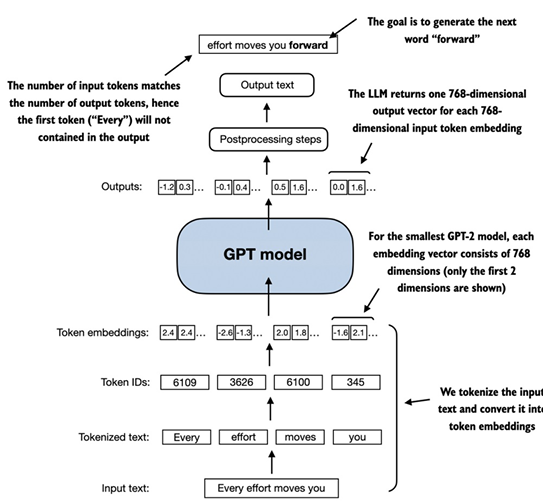

We will tokenize the batch of 2 input texts.

In [5]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


Next, we feed the tokenized batch to the model.

In [6]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


## 4.2 Normalizing activations with layer normalization

We will implement layer normalization to improve the
 stability and efficiency of neural network training.

The main idea behind layer normalization is to adjust the activations
 (outputs) of a neural network layer to have a mean of 0 and a variance of 1.

Layer normalization is typically applied
 before and after the multi-head attention module and before the final output
 layer.

Let's see how layer normalization works by passing a small input sample through a simple neural network layer:

In [7]:
torch.manual_seed(123)

# create 2 training examples with 5 dimensions (features) each
batch_example = torch.randn(2, 5) 

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


Let's compute the mean and variance for each of the 2 inputs above:

In [8]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


 Using keepdim=True in operations like mean or variance calculation ensures
 that the output tensor retains the same shape as the input tensor, even though
 the operation reduces the tensor along the dimension specified via dim.

An illustration of the dim parameter when calculating the mean of a tensor. For
 instance, if we have a 2D tensor (matrix) with dimensions [rows, columns], using dim=0 will
 perform the operation across rows (vertically, as shown at the bottom), resulting in an output
 that aggregates the data for each column. Using dim=1 or dim=-1 will perform the operation
 across columns (horizontally, as shown at the top), resulting in an output aggregating the data for
 each row.

Subtracting the mean and dividing by the square-root of the variance (standard deviation) centers the inputs to have a mean of 0 and a variance of 1 across the column (feature) dimension:

In [9]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Each input is centered at 0 and has a unit variance of 1; to improve readability, we can disable PyTorch's scientific notation:

In [10]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Now, using the same idea, we can implement a LayerNorm class:

In [11]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

Note that we also add a smaller value (eps) before computing the square root of the variance; this is to avoid division-by-zero errors if the variance is 0.

We added two trainable parameters, a scale and a shift parameter
The initial scale (multiplying by 1) and shift (adding 0) values don't have any effect; however, scale and shift are trainable parameters that the LLM automatically adjusts during training if it is determined that doing so would improve the model's performance on its training task.

In the variance calculation above, setting unbiased=False means using the formula 
 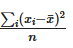
 to compute the variance where n is the sample size (here, the number of features or columns); this formula does not include Bessel's correction (which uses n-1 in the denominator), thus providing a biased estimate of the variance.

For LLMs, where the embedding dimension n is very large, the difference between using n and n-1 is negligible.

Next, we will code the LayerNorm.

In [12]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

In [13]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## 4.3 Implementing a feed forward network with GELU activations

In LLMs, various other types of activation functions are used beyond the traditional ReLU; two notable examples are GELU (Gaussian Error Linear Unit) and SwiGLU (Swish-Gated Linear Unit).

GELU and SwiGLU are more complex, smooth activation functions incorporating Gaussian and sigmoid-gated linear units, respectively, offering better performance for deep learning models.
The exact version of GeLU is defined as GELU(x)=x⋅Φ(x), where Φ(x) is the cumulative distribution function of the standard Gaussian distribution.

In practice, it's common to implement a computationally cheaper approximation:
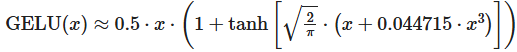

Below is the code for the GeLU.

In [14]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

Now, we try to compare the ReLU and GeLU.

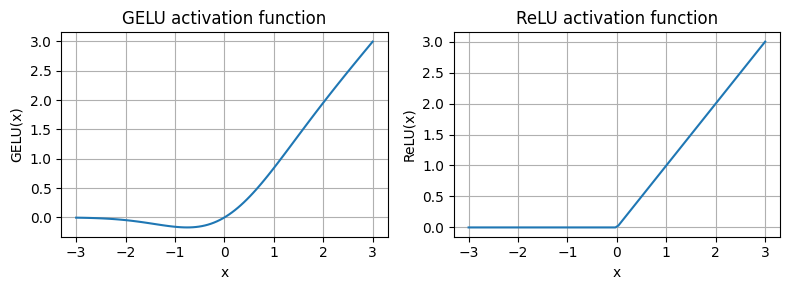

In [15]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

Here, ReLU is a piecewise linear function that outputs the input directly if it is positive; otherwise, it outputs zero.
GELU is a smooth, non-linear function that approximates ReLU but with a non-zero gradient for negative values.

The smoothness of GELU, can lead to better
 optimization properties during training, as it allows for more nuanced
 adjustments to the model's parameters. In contrast, ReLU has a sharp corner
at zero, which can sometimes make optimization harder, especially in
 networks that are very deep or have complex architectures.

Now, we will implement a small neural network module.

In [16]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [17]:
print(GPT_CONFIG_124M["emb_dim"])

768


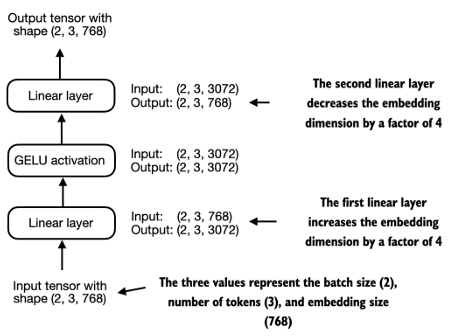

Above is the visulation of the neural netowrk.

let's initialize a new FeedForward
 module with a token embedding size of 768 and feed it a batch input with 2
 samples and 3 tokens each:

In [18]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768) 
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


The uniformity in input and output dimensions simplifies the
 architecture by enabling the stacking of multiple layers, as we will do later,
 without the need to adjust dimensions between them, thus making the model
 more scalable.

## 4.4 Adding shortcut connections

Shortcut connections(skip or residual connection) were proposed in deep networks for computer vision (residual networks) to mitigate vanishing gradient problems.

The vanishing gradient
 problem refers to the issue where gradients (which guide weight updates
 during training) become progressively smaller as they propagate backward
 through the layers, making it difficult to effectively train earlier layers.

A shortcut connection creates an alternative shorter path for the gradient to flow through the network.
This is achieved by adding the output of one layer to the output of a later layer, usually skipping one or more layers in between.

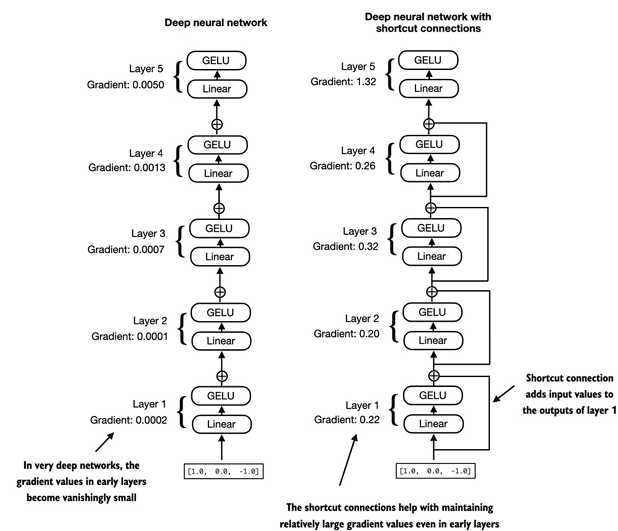

In [19]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

 In the preceding code, we specify a loss function that computes how close the
 model output and a user-specified target (here, for simplicity, the value 0)
 are. 
 
 The loss.backward(), PyTorch computes the loss
 gradient for each layer in the model. 
 
 We can iterate through the weight
 parameters via model.named_parameters(). Suppose we have a 3×3 weight
 parameter matrix for a given layer. In that case, this layer will have 3×3
 gradient values, and we print the mean absolute gradient of these 3×3
 gradient values to obtain a single gradient value per layer to compare the
 gradients between layers more easily.

the .backward() method
 computes loss gradients, which are required during model training, without
 implementing the math for the gradient calculation ourselves.

We will try to print the gradient values without shortcut connections.

In [20]:
layer_sizes = [3, 3, 3, 3, 3, 1]  

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


As we can see based on the output of the print_gradients function, the
 gradients become smaller as we progress from the last layer (layers.4) to the
 first layer (layers.0), which is a phenomenon called the vanishing gradient
 problem.

Now, we will try to do it with shortcut connections.

In [21]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472


We can infer that shortcut connections prevent the gradients from vanishing in the early layers (towards layer.0).

## 4.5 Connecting attention and linear layers in a transformer block

A transformer block combines the causal multi-head attention module with the linear layers, the feed forward neural network. We will also use dropout and shortcut connections.

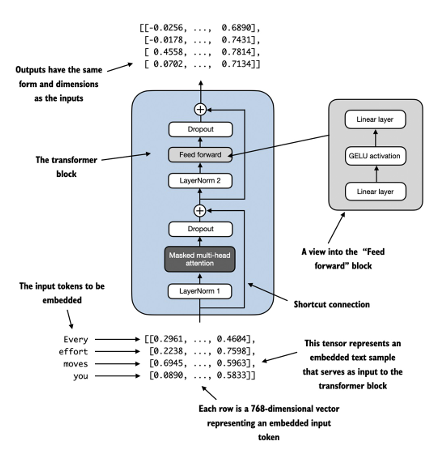

When a transformer block processes an input sequence, each element in the
 sequence (for example, a word or subword token) is represented by a fixed
size vector. 

The operations
 within the transformer block, including multi-head attention and feed forward
 layers, are designed to transform these vectors in a way that preserves their
 dimensionality.

The idea is that the self-attention mechanism in the multi-head attention
 block identifies and analyzes relationships between elements in the input
 sequence. 
 
 In contrast, the feed forward network modifies the data
 individually at each position. This combination not only enables a more
 nuanced understanding and processing of the input but also enhances the
 model's overall capacity for handling complex data patterns.

In [22]:
from previous_chapters import MultiHeadAttention


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

 Layer normalization (LayerNorm) is applied before each of these two
 components, and dropout is applied after them to regularize the model and
 prevent overfitting. This is also known as Pre-LayerNorm. 
 
 Older
 architectures, such as the original transformer model, applied layer
 normalization after the self-attention and feed-forward networks instead,
 known as Post-LayerNorm, which often leads to worse training dynamics.

The class also implements the forward pass, where each component is
 followed by a shortcut connection that adds the input of the block to its
 output. This critical feature helps gradients flow through the network during
 training and improves the learning of deep models.

Suppose we have 2 input samples with 6 tokens each, where each token is a 768-dimensional embedding vector; then this transformer block applies self-attention, followed by linear layers, to produce an output of similar size.

In [23]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


The preservation of shape throughout the transformer block architecture enables its
 effective application across a wide range of sequence-to-sequence tasks,
 where each output vector directly corresponds to an input vector, maintaining
 a one-to-one relationship. 
 
 However, the output is a context vector that
 encapsulates information from the entire input sequence. This means that while the physical dimensions of the sequence
 (length and feature size) remain unchanged as it passes through the
 transformer block, the content of each output vector is re-encoded to integrate
 contextual information from across the entire input sequence.

## 4.6 Coding the GPT model

Starting from the bottom, tokenized text is first converted into token
 embeddings, which are then augmented with positional embeddings. 
 
 This combined information
 forms a tensor that is passed through a series of transformer blocks shown in the center (each
 containing multi-head attention and feed forward neural network layers with dropout and layer
 normalization), which are stacked on top of each other and repeated 12 times.

  The output from the final transformer block then
 goes through a final layer normalization step before reaching the linear output
 layer. 
 This layer maps the transformer's output to a high-dimensional space
(in this case, 50,257 dimensions, corresponding to the model's vocabulary
 size) to predict the next token in the sequence.

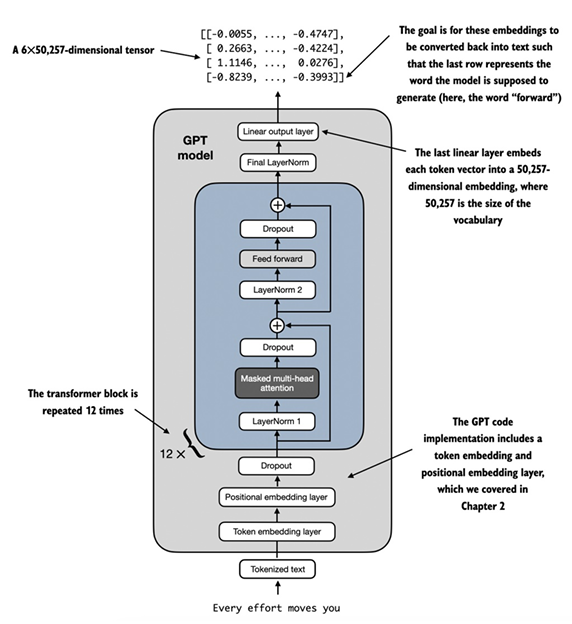

The corresponding code implementation, where cfg["n_layers"] = 12:

In [24]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

The \__init__ constructor of this GPTModel class initializes the token and
 positional embedding layers using the configurations passed in via a Python
 dictionary, cfg. 
 
 These embedding layers are responsible for converting input
 token indices into dense vectors and adding positional information.

Next, the \__init__ method creates a sequential stack of TransformerBlock
 modules equal to the number of layers specified in cfg. 
 
 Following the
 transformer blocks, a LayerNorm layer is applied, standardizing the outputs
 from the transformer blocks to stabilize the learning process. 
 
 Finally, a linear
 output head without bias is defined, which projects the transformer's output
 into the vocabulary space of the tokenizer to generate logits for each token in
 the vocabulary.

 The forward method takes a batch of input token indices, computes their
 embeddings, applies the positional embeddings, passes the sequence through
 the transformer blocks, normalizes the final output, and then computes the
 logits, representing the next token's unnormalized probabilities.

Using the configuration of the 124M parameter model, we can now instantiate this GPT model with random initial weights:

In [25]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


Using the numel() method, short for "number of elements," we can collect
 the total number of parameters in the model's parameter tensors:

In [26]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In the original GPT-2 paper, the researchers applied weight tying, which means that they reused the token embedding layer (tok_emb) as the output layer, which means setting self.out_head.weight = self.tok_emb.weight.

In [27]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


So, the embedding and output layer have the same number of weight parameters, as we can see based on the shape of their weight matrices.

Let's remove the output
 layer parameter count from the total GPT-2 model count according to the
 weight tying:

In [28]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


Weight tying reduces the overall memory footprint and computational
 complexity of the model.

 let us compute the memory requirements of the 163 million
 parameters in our GPTModel object:

In [29]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


## 4.7 Generating text

A generative model like an LLM generates text one
 word (or token) at a time.
 
 Starting with an initial input context ("Hello, I am"), the model predicts a
 subsequent token during each iteration, appending it to the input context for the next round of
 prediction.

The process by which a GPT model goes from output tensors to generated
 text involves several steps given below.

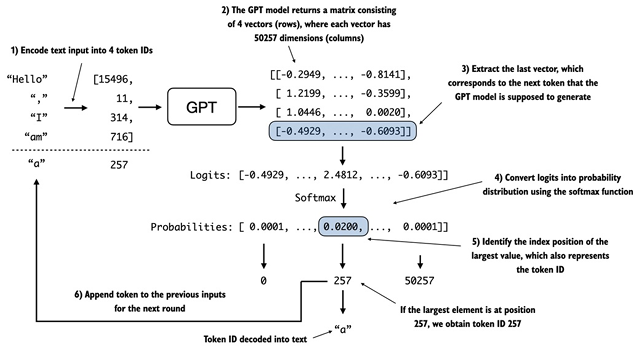

We will now code for the token generation proces.

In [30]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx


In the preceeding code, the generate_text_simple function, we use a
 softmax function to convert the logits into a probability distribution from
 which we identify the position with the highest value via torch.argmax. 
 
 The
 softmax function is monotonic, meaning it preserves the order of its inputs
 when transformed into outputs. So, in practice, the softmax step is redundant
 since the position with the highest score in the softmax output tensor is the
 same position in the logit tensor. In other words, we could apply the
 torch.argmax function to the logits tensor directly and get identical results.

However, we coded the conversion to illustrate the full process of
 transforming logits to probabilities, which can add additional intuition, such
 as that the model generates the most likely next token, which is known as
 greedy decoding.

Let's prepare an input example:

In [31]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


Next, we put the model into .eval() mode, which disables random
 components like dropout, which are only used during training, and use the
 generate_text_simple function on the encoded input tensor:

In [32]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))


Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


Using the .decode method of the tokenizer, we can convert the IDs back into
 text:

In [33]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


The reason why the model is unable to produce coherent text is
 that we haven't trained it yet.